# Calibrate camera

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## collect coefficient for undistort

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### get the undistortion coefficient

True

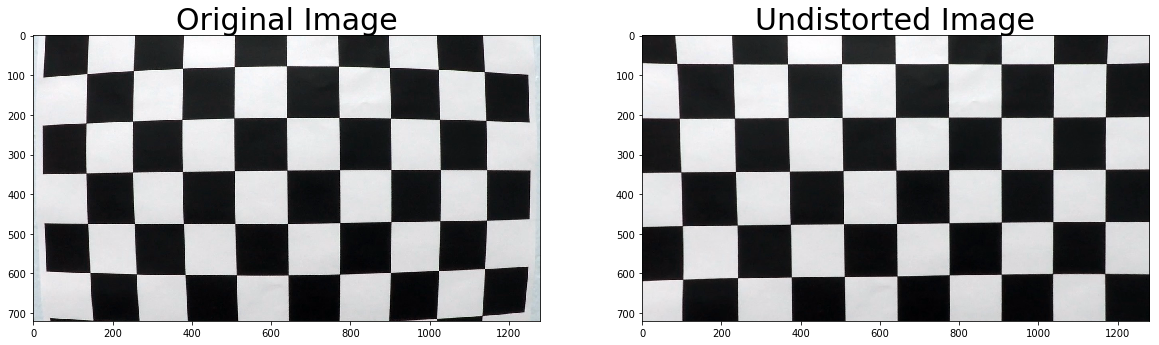

In [3]:
%matplotlib inline

# Test undistortion on an image
test_calib_img = cv2.imread('camera_cal/calibration1.jpg')
calib_img_size = (test_calib_img.shape[1], test_calib_img.shape[0])

# Do camera calibration given object points and image points
ret, CALIBRATION_MTX, CALIBRATION_DIST, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, calib_img_size,None,None)

undist_calib_img = cv2.undistort(test_calib_img, CALIBRATION_MTX, CALIBRATION_DIST, None, CALIBRATION_MTX)
#cv2.imwrite('output_image/test_undist.jpg',undist_calib_img)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_calib_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_calib_img)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.imwrite('output_images/test_undist.jpg',undist_calib_img)

### get the matrix for transforming perspective

In [4]:
straight_bgr = cv2.imread('test_images/straight_lines1.jpg')
undist_straight = cv2.undistort(straight_bgr, CALIBRATION_MTX, CALIBRATION_DIST, None, CALIBRATION_MTX)

cv2.imwrite('output_images/undist_straight.jpg',undist_straight)

True

True

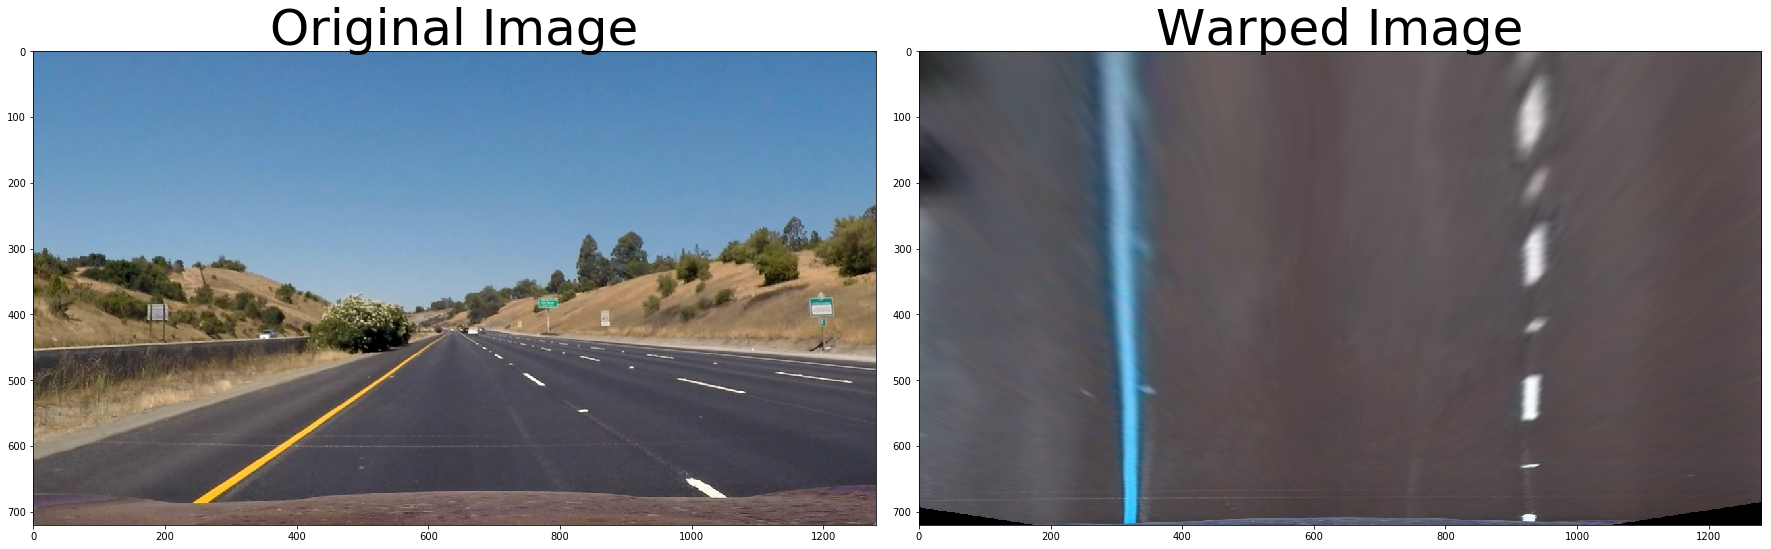

In [5]:
straight_image = mpimg.imread('test_images/straight_lines1.jpg')
st_image_shape = straight_image.shape

src_bottom_left = [208,718] 
src_bottom_right = [1092, 718]
src_top_left = [603, 447]
src_top_right = [678, 447]

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
sq_bottom_left = [320,720] 
sq_bottom_right = [920, 720]
sq_top_left = [320, 1]
sq_top_right = [920, 1]

warp_square = np.float32([sq_bottom_left,sq_bottom_right,sq_top_right,sq_top_left])
source_rect = np.float32([src_bottom_left,src_bottom_right,src_top_right,src_top_left])
PERS_M = cv2.getPerspectiveTransform(source_rect, warp_square)
PERS_M_inv = cv2.getPerspectiveTransform(warp_square, source_rect)
st_img_size = (st_image_shape[1], st_image_shape[0])

test_warped_img = cv2.warpPerspective(
    undist_straight, PERS_M, st_img_size , flags=cv2.INTER_LINEAR
)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_warped_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('output_images/warped.jpg',test_warped_img)

#  apply sobel and color threshold to find the lanes

### abs sobel

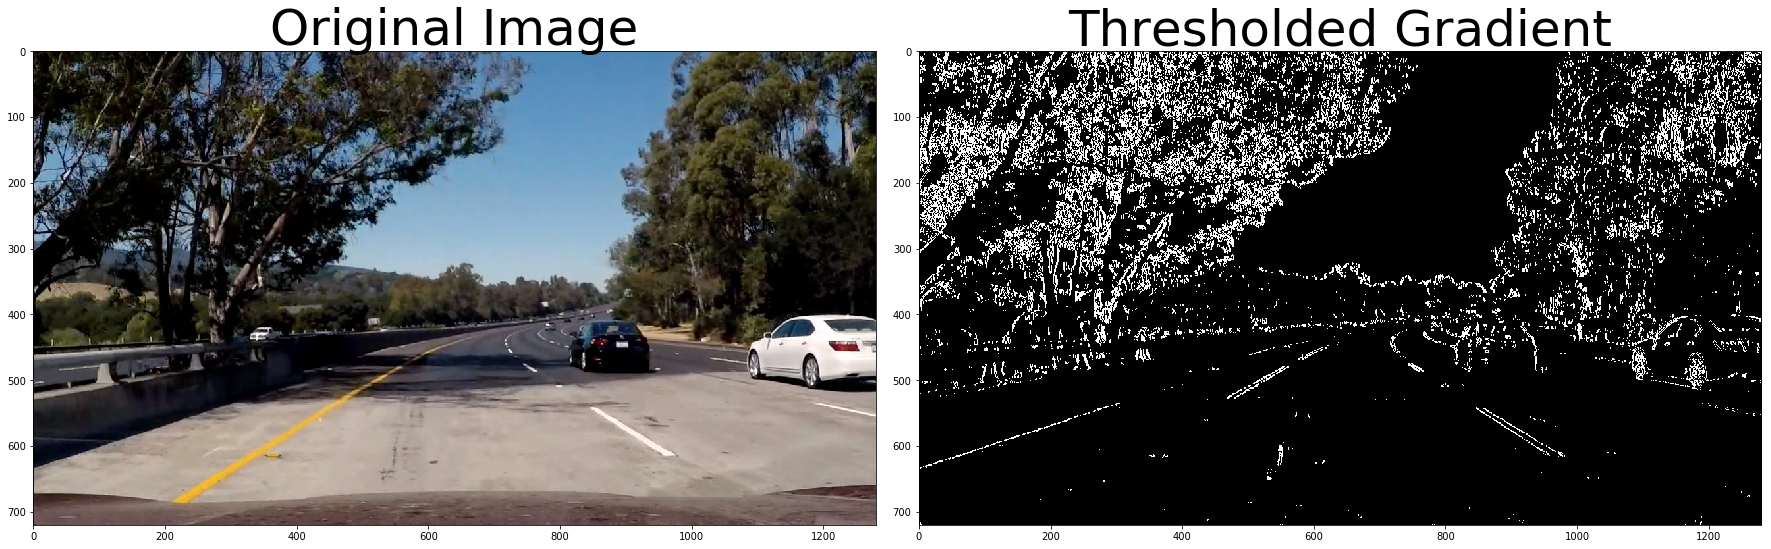

In [6]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    img = np.copy(img)
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        x_dir = 1
        y_dir = 0
    elif orient == 'y':
        x_dir = 0
        y_dir = 1
    sobel = cv2.Sobel(img, cv2.CV_64F, x_dir, y_dir, ksize=sobel_kernel)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Run the function
abs_test_image = mpimg.imread('test_images/test5.jpg')
grad_binary = abs_sobel_thresh(abs_test_image, orient='x', sobel_kernel=3, thresh=(20, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(abs_test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### magnitude of the gradient

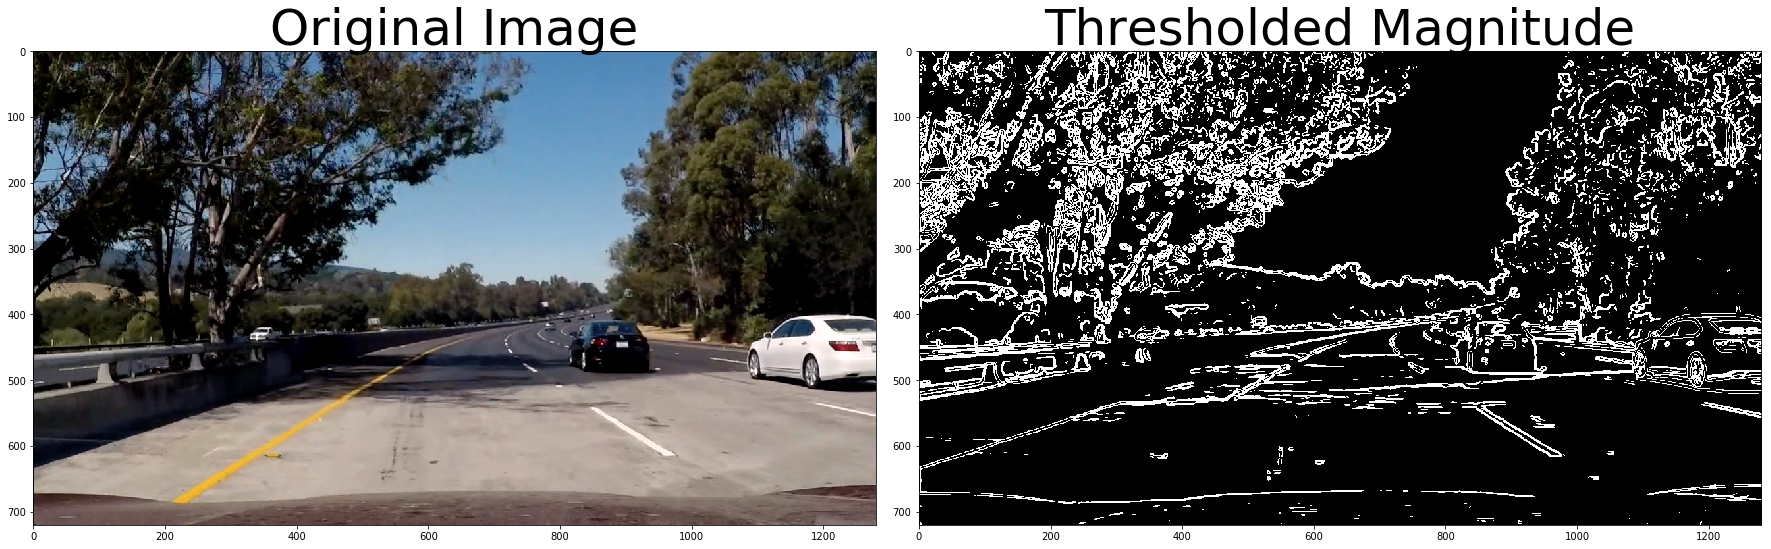

In [7]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    img = np.copy(img)
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    mag = np.uint8(255*(mag/np.max(mag)))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(mag)
    binary_output[(mag > mag_thresh[0]) & (mag < mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Read in an image
mag_test_image = mpimg.imread('test_images/test5.jpg')
# Run the function
mag_binary = mag_thresh(mag_test_image, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mag_test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Direction of the Gradient

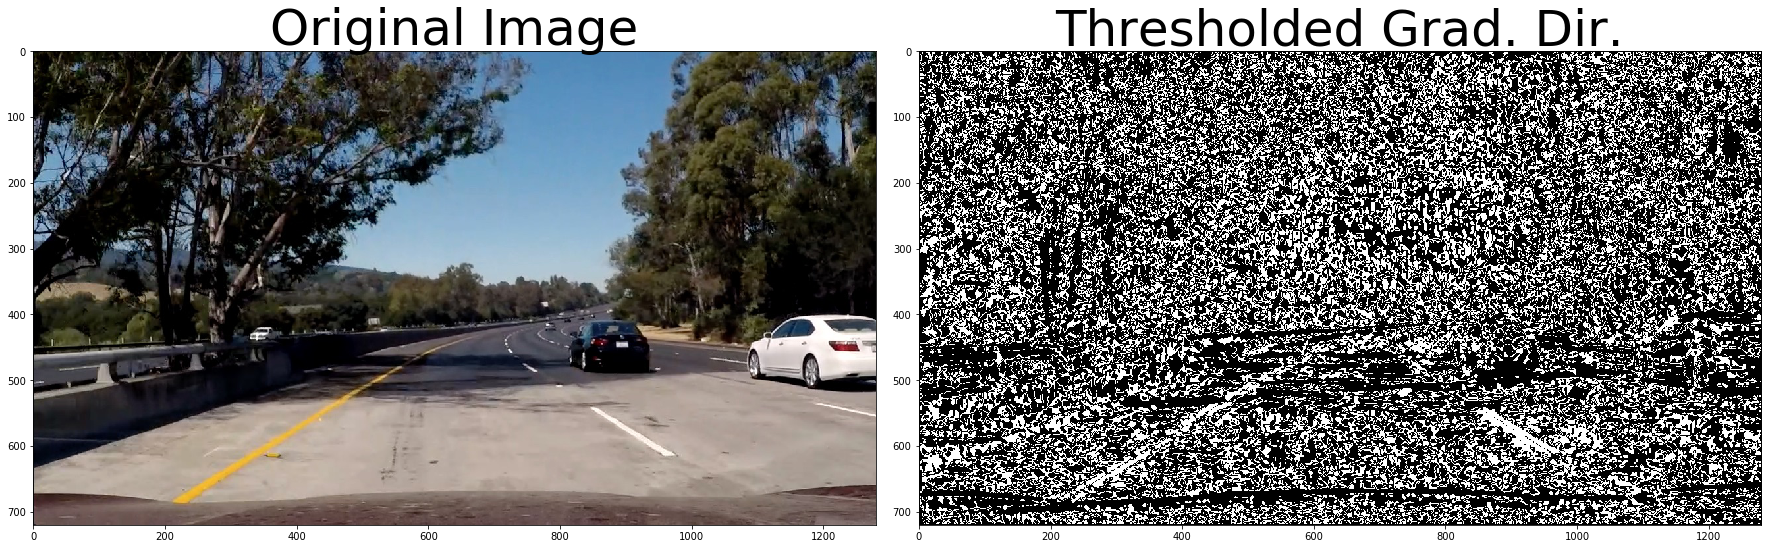

In [8]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    img = np.copy(img)
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arct_sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arct_sobel)
    binary_output[(arct_sobel > thresh[0]) & (arct_sobel < thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output
    
    
# Read in an image
dir_test_image = mpimg.imread('test_images/test5.jpg')

# Run the function
dir_binary = dir_threshold(dir_test_image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dir_test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### s channel

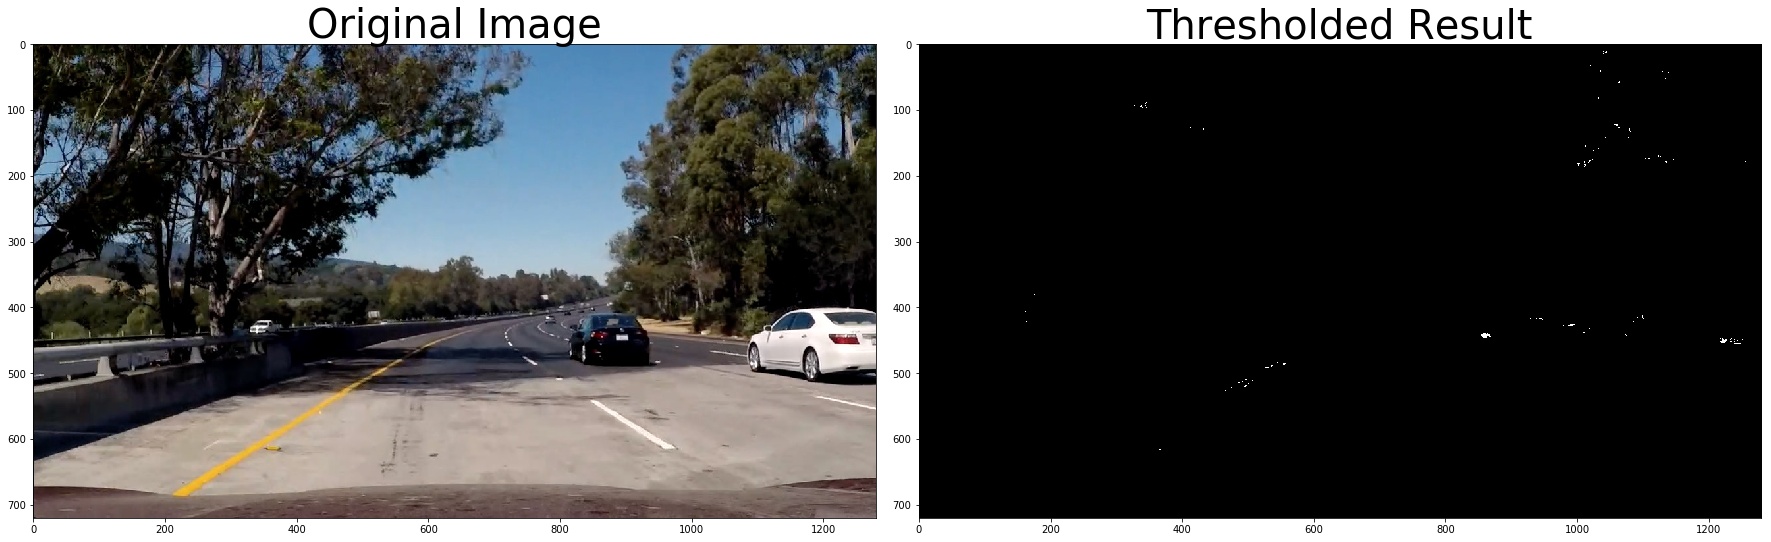

In [18]:
def color_channel_binary(img, s_thresh=(170, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    # Sobel x
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    binary = np.zeros_like(s_channel)
    binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # binary[((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) | ((h_channel >= 170) & (h_channel <= 255))] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # return color_binary
    return binary

s_image = mpimg.imread('test_images/test5.jpg')
result = color_channel_binary(s_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(s_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### combine binary

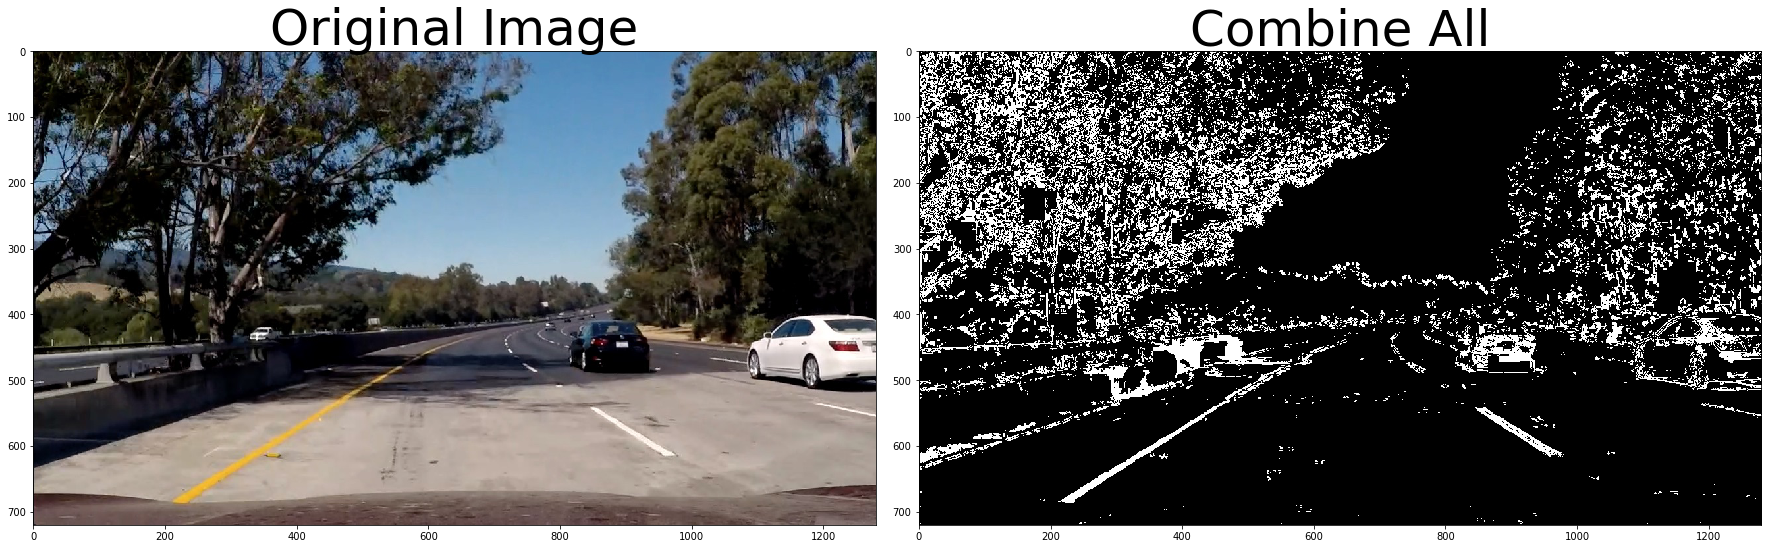

In [10]:
def combine_binary(image):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    col_binary = color_channel_binary(image)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary==1)] = 1
    # combined[(gradx == 1) | (col_binary==1)] = 1
    # combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary==1)] = 1
    return combined

# Run the function
comb_image = mpimg.imread('test_images/test5.jpg')
combined = combine_binary(comb_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mpimg.imread('test_images/test5.jpg'))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combine All', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#cv2.imwrite('output_images/threshold_binary.png', combined, cv2.IMWRITE_PXM_BINARY)

### warp and threshold

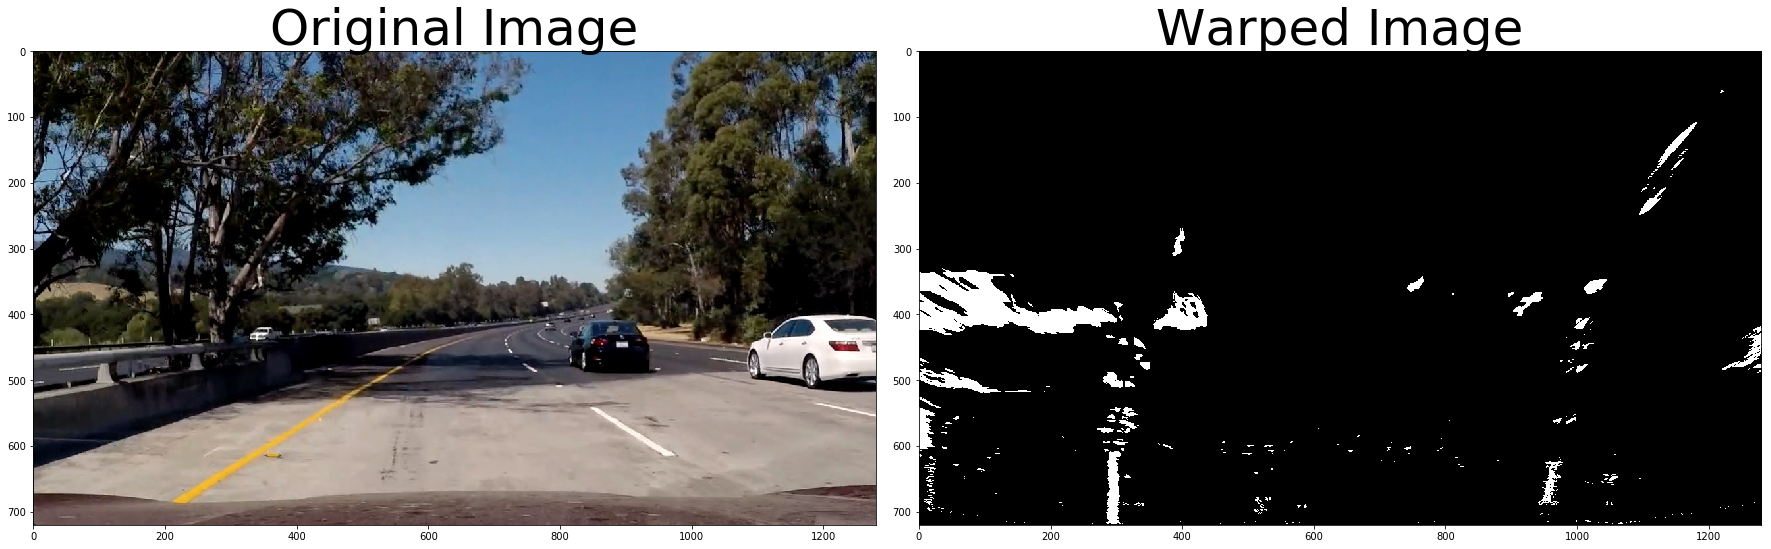

In [11]:
def warp_and_threshold(image):
    undist_img = cv2.undistort(image, CALIBRATION_MTX, CALIBRATION_DIST, None, CALIBRATION_MTX)
    warped_img = cv2.warpPerspective(
        undist_img, PERS_M, (undist_img.shape[1], undist_img.shape[0]), flags=cv2.INTER_LINEAR
    )
    combined_bin = combine_binary(warped_img)

    result = combined_bin
    return undist_img, combined_bin

# Run the function
warp_tes_image = mpimg.imread('test_images/test5.jpg')
_, warped_test_binary = warp_and_threshold(warp_tes_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mpimg.imread('test_images/test5.jpg'))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_test_binary, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# find line

### Line Class

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # for drawing
        self.lane_inds = None

### get line pixel by sliding window

In [13]:
def sliding_window(binary_warped, left_line, right_line):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    left_line.lane_inds = left_lane_inds
    right_line.lane_inds = right_lane_inds
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # Define conversions in x and y from pixels space to meters
    left_line.current_fit = np.polyfit(lefty, leftx, 2)
    right_line.current_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_line.ally = ploty
    right_line.ally = ploty
    left_line.allx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    right_line.allx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_left_eval = np.max(lefty)
    y_right_eval = np.max(righty)
    left_line.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_left_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_line.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_right_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    left_line.detected = True
    right_line.detected = True
    
    # Calculate the center of lane
    bottom_leftx = left_line.current_fit[0]*y_left_eval**2 + left_line.current_fit[1]*y_left_eval + left_line.current_fit[2]
    bottom_rightx = right_line.current_fit[0]*y_right_eval**2 + right_line.current_fit[1]*y_right_eval + right_line.current_fit[2]
    center = (bottom_leftx + bottom_rightx) / 2
    left_line.line_base_pos = (center - bottom_leftx) * xm_per_pix
    right_line.line_base_pos = (bottom_rightx- center) * xm_per_pix

### get line pixel by polynomial

In [14]:
def get_line_by_polynomial(binary_warped, left_line, right_line,image):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_line.diffs = left_line.current_fit - left_fit
    left_line.current_fit = left_fit
    right_line.diffs = right_line.current_fit - right_fit
    right_line.current_fit = right_fit
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_line.ally = ploty
    right_line.ally = ploty
    left_line.allx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_line.allx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_left_eval = np.max(lefty)
    y_right_eval = np.max(righty)
    left_curve = ((1 + (2*left_fit_cr[0]*y_left_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve = ((1 + (2*right_fit_cr[0]*y_right_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # sanity check
    if abs(left_curve) - 1 > abs(left_line.radius_of_curvature):
        left_line.detected = False
    if abs(right_curve) - 1 > abs(right_line.radius_of_curvature):
        right_line.detected = False
    if abs(left_curve) -1 > abs(right_curve):
        left_line.detected = False
        right_line.detected = False
    
    left_startx = left_fit[0]*y_left_eval**2 + left_fit[1]*y_left_eval + left_fit[2]
    right_startx = right_fit[0]*y_right_eval**2 + right_fit[1]*y_right_eval + right_fit[2]
    if right_startx - left_startx < 600:
        left_line.detected = False
        right_line.detected = False
        
    left_line.radius_of_curvature = left_curve
    right_line.radius_of_curvature = right_curve
    
    # Calculate the center of lane
    bottom_leftx = left_line.current_fit[0]*y_left_eval**2 + left_line.current_fit[1]*y_left_eval + left_line.current_fit[2]
    bottom_rightx = right_line.current_fit[0]*y_right_eval**2 + right_line.current_fit[1]*y_right_eval + right_line.current_fit[2]
    center = (bottom_leftx + bottom_rightx) / 2
    left_line.line_base_pos = (center - bottom_leftx) * xm_per_pix
    right_line.line_base_pos = (bottom_rightx- center) * xm_per_pix

### draw the area

In [15]:
def draw_area(image, undist, warped_image, left_line, right_line):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.allx, left_line.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.allx, right_line.ally])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, PERS_M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate the center of lane
    lane_center = (left_line.allx[719] + right_line.allx[719]) / 2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    difference = (lane_center - image.shape[1]/2.0) * xm_per_pix
    direction = 'right' if difference > 0 else 'left'
    cv2.putText(result,str(np.absolute(difference))+'[m]' + direction +' from center',(300,50),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255))
    cv2.putText(result,'Left curvature: '+str(left_line.radius_of_curvature)+'[m]  Right curvature: '+str(right_line.radius_of_curvature)+'[m]',(0,100),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255))
    return result

### define handler of each frame

/Users/takabatakekoichi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


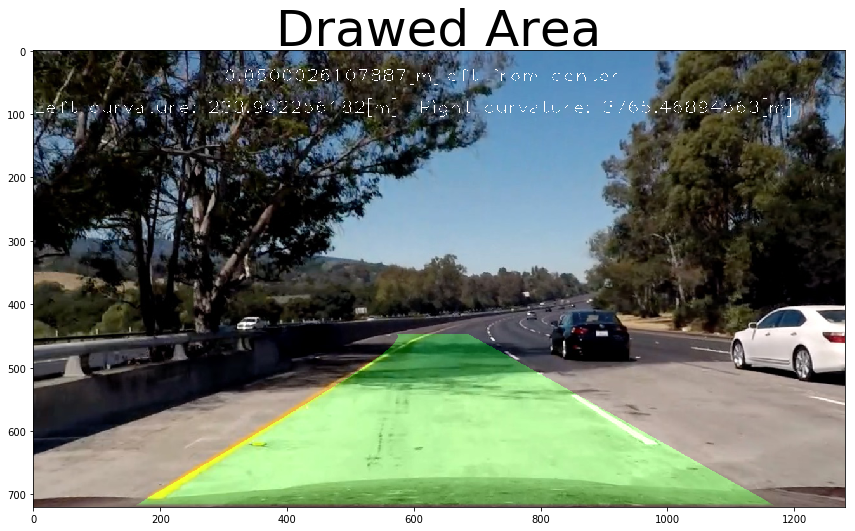

In [16]:
left_line = Line()
right_line = Line()

def process_image(image):
    undist, binary_warped = warp_and_threshold(image)
    if left_line.detected == True and right_line.detected == True:
        center = get_line_by_polynomial(binary_warped, left_line, right_line,image)
    else: 
        center = sliding_window(binary_warped, left_line, right_line)
        
    result = draw_area(image, undist, binary_warped, left_line, right_line)    
    return result

# Run the function
draw_test_image = mpimg.imread('test_images/test5.jpg')
result = process_image(draw_test_image)

f, ax1 = plt.subplots(1, 1, figsize=(12, 9))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Drawed Area', fontsize=50)

#_, binary_warped = warp_and_threshold(draw_test_image)
#
#nonzero = binary_warped.nonzero()
#nonzeroy = np.array(nonzero[0])
#nonzerox = np.array(nonzero[1])
#
## Create an image to draw on and an image to show the selection window
#out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#window_img = np.zeros_like(out_img)
## Color in left and right line pixels
#out_img[nonzeroy[left_line.lane_inds], nonzerox[left_line.lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_line.lane_inds], nonzerox[right_line.lane_inds]] = [0, 0, 255]
#
#margin = 100
## Generate a polygon to illustrate the search window area
## And recast the x and y points into usable format for cv2.fillPoly()
#left_line_window1 = np.array([np.transpose(np.vstack([left_line.allx-margin, left_line.ally]))])
#left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.allx+margin, left_line.ally])))])
#left_line_pts = np.hstack((left_line_window1, left_line_window2))
#right_line_window1 = np.array([np.transpose(np.vstack([right_line.allx-margin, right_line.ally]))])
#right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.allx+margin, right_line.ally])))])
#right_line_pts = np.hstack((right_line_window1, right_line_window2))
#
## Draw the lane onto the warped blank image
#cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#plt.imshow(result)
#plt.plot(left_line.allx, left_line.ally, color='yellow')
#plt.plot(right_line.allx, right_line.ally, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

### apply the conversion and output the video  

In [17]:
import matplotlib.image as mpimg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [5:08:28<00:00,  1.73it/s]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 8min 24s, sys: 1min 59s, total: 10min 23s
Wall time: 5h 8min 31s


### play the video

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))